# How Convolution layer works?


- 기수: 14

- 이름: 신태희

- 작성자: 13기 강승우

압축을 해제한 폴더 그대로 경로 변경 없이 문제를 푸시면됩니다.  
**CNN assignment폴더 아래에 data폴더, CNN 노트북파일, 이미지파일이 위치해야합니다.**  
문제가 생길 경우 경로 코드를 수정하시거나, 학술부에게 문의해주세요

이번 문제에서는 직접 Convolution 연산을 구현해보며 CNN의 동작 원리를 알아보고자 합니다.

**목표**
- `nn.Conv2d`와 동일한 연산을 **NumPy로 직접 구현**
- laplacian filter와 sobel filter를 **이미지에 적용**

**라이브러리 및 함수 정의**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import Tuple, Optional

# 시각화 유틸
def show_gray(img, title=None):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def minmax_norm(x: np.ndarray, eps: float = 1e-12):
    mn, mx = np.min(x), np.max(x)
    if mx - mn < eps:
        return np.zeros_like(x)
    return (x - mn) / (mx - mn)

**이미지 준비**

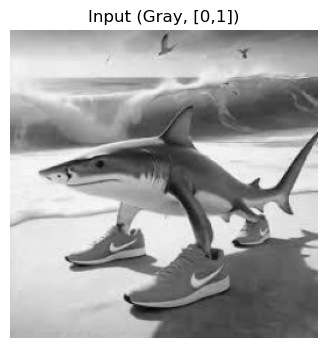

In [2]:
def load_image(path: Optional[str] = None, size: Tuple[int,int]=(256,256)) -> np.ndarray:
    img = Image.open(path).convert('L').resize(size, Image.BILINEAR)
    arr = np.array(img, dtype=np.float32) / 255.0
    return arr

# 사용 예시: path=None -> 합성 이미지
img = load_image(path="./tralla.jpg", size=(256,256))
show_gray(img, title='Input (Gray, [0,1])')


**Q1. numpy를 사용하여 이미지와 커널 배열을 입력으로 받는 conv2D_naive 함수를 구현하세요**

In [4]:
def conv2d_naive(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    image: (H, W)
    kernel: (kH, kW)

    반환: (outH, outW)
    """
    # padding=0, stride=1 조건으로 구현
    padding = 0
    padded = np.pad(image, ((padding, padding), (padding, padding)), mode='constant')
    stride = 1

    ## Todo ##
    kH, kW = kernel.shape
    H, W = image.shape
    outH = (H-kH) // stride + 1
    outW = (W-kW) // stride + 1
    out = np.zeros((outH, outW), dtype=np.float32)

    kernel_flipped = np.flip(np.flip(kernel, 0), 1)
    
    for i in range(outH):
        for j in range(outW):
            region = padded[i:i+kH, j:j+kW]
            out[i,j] = np.sum(region*kernel_flipped)


    ##########
    return out


**Q2. 작성한 코드의 동작 방식이 왜 CNN의 convolution 연산과 동일한지 아래 마크다운에 자세히 설명해주세요. (예시를 들어 설명하셔도 좋습니다)**

convolution의 핵심은 커널이 입력 위를 한 칸씩 이동하면서 해당 영역과 커널 원소를 곱해 모두 더하는 과정이며 이때 같은 커널이 전 위치에서 반복적으로 사용되므로 가중치 공유가 일어나고 지역적 특징을 효과적으로 뽑아낼 수 있다. 가령 5x5 크기의 이미지를 3x3 커널로 처리할 경우 먼저 좌상단 3x3 영역을 잘라 커널과 곱하고 합한 값을 출력의 (0,0)에 기록하고 창을 오른쪽으로 한 칸 옮겨 (0,1)을 구하는 식으로 작동한다. 위의 코드 역시 패딩을 0, stride = 1로 두고 출력 크기를 계산하며 이런 슬라이딩 연산을 수행하므로 convolution 연산과 동일하다.

**라플라시안 필터 적용 및 시각화**


- Laplace Filter  
\begin{bmatrix}
1 & 1 & 1\\
1 & -8 & 1\\
1 & 1 & 1
\end{bmatrix}

- Sobel Filter(수직)  
\begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}

- Sobel Filter(수평)
\begin{bmatrix}
-1 & -2 & -1\\
0 & 0 & 0\\
1 & 2 & 1
\end{bmatrix}


In [5]:
laplace = np.array([[ 1, 1, 1],
                    [ 1,-8, 1],
                    [ 1, 1, 1]], dtype=np.float32)

sobel_vertical = np.array([[ -1, 0, 1],
                           [ -2, 0, 2],
                           [ -1, 0, 1]], dtype=np.float32)

sobel_horizontal = np.array([[ -1, -2, -1],
                             [  0,  0,  0],
                             [  1,  2,  2]], dtype=np.float32)

print('laplace:\n', laplace)
print('sobel_vertical\n', sobel_vertical)
print('sobel_horizontal:\n', sobel_horizontal)

laplace:
 [[ 1.  1.  1.]
 [ 1. -8.  1.]
 [ 1.  1.  1.]]
sobel_vertical
 [[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]
sobel_horizontal:
 [[-1. -2. -1.]
 [ 0.  0.  0.]
 [ 1.  2.  2.]]


**구현한 Conv함수와 주어진 filter로 이미지의 edge를 검출해보세요**
- 결과의 범위가 음수가 될 수 있어, 시각화를 위해 정규화 사용

In [6]:
def apply_filter_and_visualize(img: np.ndarray, kernel: np.ndarray, stride: int = 1):

    resp = conv2d_naive(img, kernel)
    resp_signed = minmax_norm(resp)      # [-?, +?] -> [0,1] 정규화
    
    show_gray(img, 'Input')
    show_gray(resp_signed, 'Laplacian response (signed → min-max normalized)')
    return resp

=== Laplacian ===


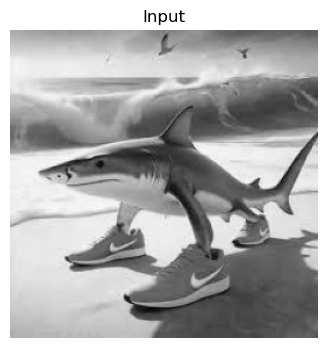

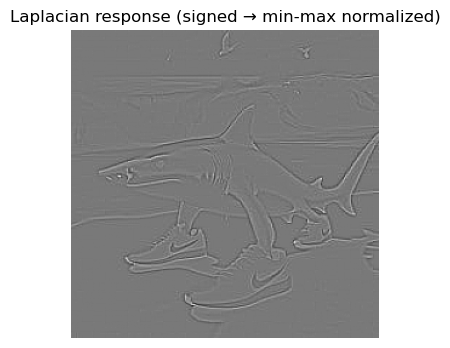

=== Sobel Vertical ===


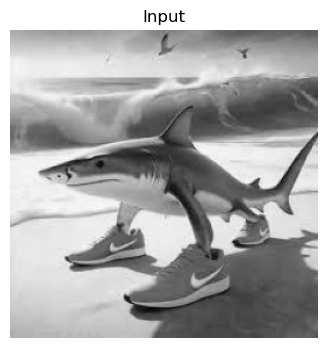

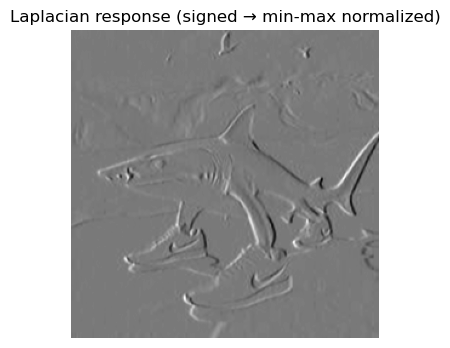

=== Sobel Horizontal ===


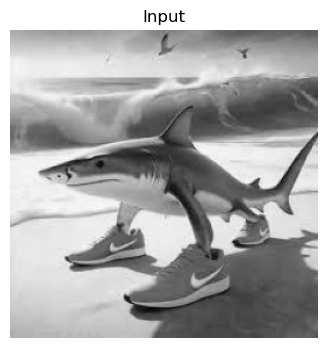

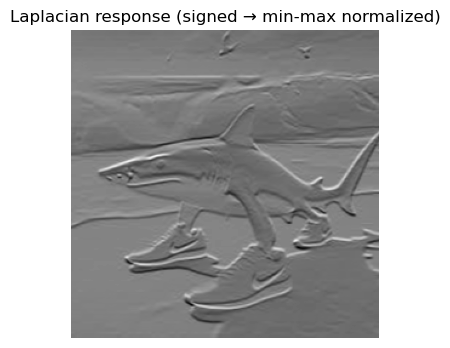

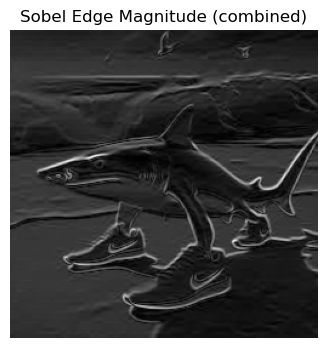

In [7]:
print('=== Laplacian ===')
resp_lp = apply_filter_and_visualize(img, laplace)

print('=== Sobel Vertical ===')
resp_sv = apply_filter_and_visualize(img, sobel_vertical)

print('=== Sobel Horizontal ===')
resp_sh = apply_filter_and_visualize(img, sobel_horizontal)

edge_mag = np.sqrt(resp_sv**2 + resp_sh**2)
edge_mag = minmax_norm(edge_mag)

show_gray(edge_mag, 'Sobel Edge Magnitude (combined)')

# Resnet18 구현하기

앞선 문제에서 Convolution 연산을 구현하여 보았으니,  
이번에는 **Resnet18을 직접 구현**해보고자 합니다.  
**Pytorch의 nn.Conv2d를 사용하시면 되지만**,  
본인이 구현한 Conv2d가 backward 연산이 가능하도록 설계되었다면 그것을 사용하여 구현하셔도 좋습니다.

**라이브러리 및 함수 정의**

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

data_path = "./data"

batch_size = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform) 
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:11<00:00, 14.6MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
def train(model, trainloader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.01,
        weight_decay=5e-4,
        momentum=0.9
    )
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(trainloader,desc=f'Epoch {epoch+1}/{epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(trainloader)}")

def test(model, testloader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

**Q1. CIFAR10 데이터셋을 분류하는 Resnet18 classifier를 구현하세요**

Input (Batch size x 3 x 32 x 32) / Output (Batch size x Num class)  
이미지 배치를 입력받아 label 개수에 맞는 logit을 반환하도록 BasicBlock과 ResNet18 class를 정의해주세요.  
**ImageNet(224x224)을 입력으로 받는 Original ResNet18과 달리 CIFAR10(32x32)을 입력으로 받으므로,**  
- **conv1과 conv2 layer의 filter size와, maxpooling, stride,**  
- **fc layer의 output dimension을 적절히 변형하셔야 합니다.**
- **ResNet의 Architecture는 아래와 같습니다**

![사진](./ResNet_Architectures.png)

In [12]:
class BasicBlock(nn.Module):
    
    #### Todo ####
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1) -> None:
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )



    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
    ##############



class ResNet18(nn.Module):


    ###### Todo ######

    def __init__(self, num_classes=10) -> None:
        super(ResNet18, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*BasicBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels*block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out=self.avgpool(out)
        out = torch.flatten(out,1)
        out=self.fc(out)

        return out
    
    ##################

모델이 안정적으로 학습되는지, 테스트 정확도가 잘 나오는지 (80% 이상) 확인해보세요

In [13]:
torch.manual_seed(42)
model = ResNet18().to(device)
train(model, trainloader, epochs=20)

Epoch 1/20: 100%|██████████| 500/500 [15:04<00:00,  1.81s/it]


Epoch 1/20, Loss: 1.2631632714271546


Epoch 2/20: 100%|██████████| 500/500 [15:02<00:00,  1.80s/it]


Epoch 2/20, Loss: 0.7371331408023835


Epoch 3/20: 100%|██████████| 500/500 [15:25<00:00,  1.85s/it]


Epoch 3/20, Loss: 0.5202632026076317


Epoch 4/20: 100%|██████████| 500/500 [15:46<00:00,  1.89s/it]


Epoch 4/20, Loss: 0.3803453599214554


Epoch 5/20: 100%|██████████| 500/500 [15:18<00:00,  1.84s/it]


Epoch 5/20, Loss: 0.2737992801964283


Epoch 6/20: 100%|██████████| 500/500 [15:04<00:00,  1.81s/it]


Epoch 6/20, Loss: 0.18999535225331785


Epoch 7/20: 100%|██████████| 500/500 [15:11<00:00,  1.82s/it]


Epoch 7/20, Loss: 0.13800003851205112


Epoch 8/20: 100%|██████████| 500/500 [15:12<00:00,  1.82s/it]


Epoch 8/20, Loss: 0.0973536638841033


Epoch 9/20: 100%|██████████| 500/500 [18:25<00:00,  2.21s/it]


Epoch 9/20, Loss: 0.07089507649093867


Epoch 10/20: 100%|██████████| 500/500 [16:36<00:00,  1.99s/it]


Epoch 10/20, Loss: 0.05360021934565157


Epoch 11/20: 100%|██████████| 500/500 [19:01<00:00,  2.28s/it]


Epoch 11/20, Loss: 0.053651458603329955


Epoch 12/20: 100%|██████████| 500/500 [18:51<00:00,  2.26s/it]


Epoch 12/20, Loss: 0.047424437837675214


Epoch 13/20: 100%|██████████| 500/500 [17:50<00:00,  2.14s/it]


Epoch 13/20, Loss: 0.029297075954731553


Epoch 14/20: 100%|██████████| 500/500 [18:09<00:00,  2.18s/it]


Epoch 14/20, Loss: 0.023982012052088976


Epoch 15/20: 100%|██████████| 500/500 [17:23<00:00,  2.09s/it]


Epoch 15/20, Loss: 0.01243198639410548


Epoch 16/20: 100%|██████████| 500/500 [15:48<00:00,  1.90s/it]


Epoch 16/20, Loss: 0.0037971660659532063


Epoch 17/20: 100%|██████████| 500/500 [17:38<00:00,  2.12s/it]


Epoch 17/20, Loss: 0.0012506610437412746


Epoch 18/20: 100%|██████████| 500/500 [17:21<00:00,  2.08s/it]


Epoch 18/20, Loss: 0.0009146130337030627


Epoch 19/20: 100%|██████████| 500/500 [17:35<00:00,  2.11s/it]


Epoch 19/20, Loss: 0.0007358975672104862


Epoch 20/20: 100%|██████████| 500/500 [17:39<00:00,  2.12s/it]

Epoch 20/20, Loss: 0.0007317783026373945


In [14]:
test(model, testloader, device)

Test Accuracy: 86.33%


86.33

**Q2. Original ResNet18과 CIFAR10 분류용으로 구현한 ResNet18의 차이점과 그렇게 수정한 이유를 아래 마크다운에 자세히 설명해주세요.**

Original ResNet18은 224x224인 ImageNet 이미지를 대상으로 설계되어 첫 conv1이 7x7, stride=2이고 뒤에 3x3 max pooling이 있어 공간해상도가 크게 줄어든다. 반면 CIFAR10은 32x32로 작기 때문에 그대로 적용하면 초기 특징 정보가 손실되므로 conv1을 3x3, stride=1로 바꾸고 max pooling을 제거했다. 또한 fc 레이어 출력도 CIFAR10 클래스 수인 10으로 조정하여 작은 이미지에서도 충분한 공간 정보를 유지하며 특징을 학습할 수 있도록 했다.